In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import math
import skimage
from skimage import morphology
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage import img_as_uint
from skimage import io
from skimage import util
from scipy.ndimage.filters import convolve
from scipy import signal
from skimage.filters import threshold_otsu
from skimage.filters import rank
from skimage import img_as_float #convert img, we should use this function. Do Not Use np.astype

#np.set_printoptions(threshold=np.nan)


In [4]:
def show_on_jupyter(showImg,color= None,tempTitle=None):
    if color == 'gray':
        plt.axis("off")
        plt.title(tempTitle)
        plt.imshow(showImg,cmap=color)
        plt.show()
    elif color == None:
        plt.axis("off")
        plt.title(tempTitle)
        plt.imshow(cv2.cvtColor(showImg, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Gray or None")
        exit(-1)

In [6]:
'''
How to convert to skimage -> opencv 
    cvImg = skimage.astype("float") 
    cvimg = skimage.img_as_ubyte(skimage)

'''
class khanMethod2016:    
    
    ## first, normalized data.
    ## second, split the channel
    ## and use green ch image.
    ## skimage + opencv model. 
    ## class priviate params are under init function. (self.ori~~ etc...)
    def __init__(self, imgPath, maskPath = None):
        #################### class Parameter ##############################
        self.oriImg = None ; self.greenImg = None ; self.claheImg = None ;self.maskPath = None
        self.tophatImg = None; self.hessImg = None;
        self.hessDiff1 = None; self.hessDiff2 = None
        self.imgCol = None; self.imgRow = None
        
        self.strucEle1 = np.array([[0,0,1,1,1,1,1,1,1,1,1,0,0],
                                [0,1,1,1,1,1,1,1,1,1,1,1,0],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                [0,1,1,1,1,1,1,1,1,1,1,1,0],
                                [0,0,1,1,1,1,1,1,1,1,1,0,0]],dtype='uint8')
        
        self.strucEle2 = np.array([[0,0,1,1,1,1,1,0,0],
                                   [0,1,1,1,1,1,1,1,0],
                                   [1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1],
                                   [0,1,1,1,1,1,1,1,0],
                                   [0,0,1,1,1,1,1,0,0]],dtype='uint8')
        
        self.strucEle3 = np.array([[0,0,1,1,1,1,1,1,1,0,0],
                                   [0,1,1,1,1,1,1,1,1,1,0],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [1,1,1,1,1,1,1,1,1,1,1],
                                   [0,1,1,1,1,1,1,1,1,1,0],
                                   [0,0,1,1,1,1,1,1,1,0,0]],dtype='uint8')
        
        ##################################################################
        
        self.oriImg =  cv2.imread(imgPath)
        self.maskPath = maskPath
        self.imgRow, self.imgCol, tempOriCh = self.oriImg.shape ## Row, Col, ch

        tempRed = self.oriImg[:,:,0]; tempGreen = self.oriImg[:,:,1] ; tempBlue = self.oriImg[:,:,2]
        #tempRed,tempGreen,tempBlue = cv2.split(tempNorm)
        tempNorm = cv2.normalize(img_as_float(tempGreen), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point

        print(tempGreen[10,:10])
        self.greenImg = tempNorm

        show_on_jupyter(self.oriImg,tempTitle = 'Original')
        show_on_jupyter(self.greenImg,'gray','convert gray')
        
        ############# Check the Data type ###################
        print("#####################################################")
        print("self.oriImg : {} tempNorm : {} self.greenImg : {} ".format(self.oriImg.dtype,tempNorm.dtype,self.greenImg.dtype))
        #print(self.oriImg[10,10])
        print(self.greenImg[10,:10])
        print("#####################################################")
        #####################################################
        
        #tempGray = cv2.cvtColor(self.oriImg,cv2.COLOR_RGB2GRAY)
        #tempRed = self.oriImg[:,:,0]; tempGreen = self.oriImg[:,:,1] ; tempBlue = self.oriImg[:,:,2]
        #tempRed,tempGreen,tempBlue = cv2.split(self.oriImg)
        #cv2.imwrite("original.png",self.oriImg)
        #cv2.imwrite("greenCh.png",self.greenImg)
        
        
    ## show histogram in jupyter notebook
    ##  using opencv. (calcHist function)
    ## 2 parameter
    ## color = determine gray scale or RGB scale
    ## dtype = determine data type like uint or float
    
    def show_histogram(self,img,color = None, dtype = 'int'):
        # hist,bins = np.histogram(img.flatten(),256,[0,256])
        if (color == None) and (dtype =='int'):
            color = ('b','g','r')
            for i,col in enumerate(color):
            #    print(i,col)
                histr = cv2.calcHist([img],[i],None,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
        if (color == None) and (dtype =='float'):
            color = ('b','g','r')
            for i,col in enumerate(color):
            #    print(i,col)
                histr = cv2.calcHist([img],[i],None,[256],[0,1])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
        elif (color == 'gray')and (dtype=='float') :
            #hist,bins = cv2.calcHist([img], [0], None, [256], [0,256])
            #print("bins : " ,bins,"\nbins.len : ",len(bins))
            #print(img.ravel())
            plt.hist(img.ravel(),256,[img.min(),img.max()])
            plt.title('Histogram for gray scale picture')
            plt.show()
        elif (color == 'gray') and (dtype == 'int'):
            plt.hist(img.ravel(),256,[0,256])
            plt.title('Histogram for gray scale picture')
            plt.show()
            
    
    # calhe algorithm for preprocessing
    #  parameter = clipLimit, tileGridSize
    # this parameters are used for clahe equalization
    def clahe_preprocessing(self,clipParam = 0.01, gridParam = (31,31)):
        tempImg = self.greenImg
        tempImg = cv2.normalize(img_as_float(tempImg), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point

        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print(tempImg[10,:10])
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')

        clahe = skimage.exposure.equalize_adapthist(tempImg,clip_limit= 0.01)
        #clahe = clahe.astype("float")
        #clahe = img_as_float(clahe)

        self.claheImg = clahe
        
        #CLAHE Debugging
        
        ############# Check the Data type ###################
        print("#####################################################")
        print("tempImg : {} self.claheImg : {}".format(tempImg.dtype,self.claheImg.dtype))
        print(self.claheImg[10,:10])
        print("#####################################################")
        #####################################################
        
        #print(clahe)
        self.show_histogram(tempImg, color = 'gray',dtype = 'float')
        self.show_histogram(clahe,color = 'gray',dtype = 'float')
        show_on_jupyter(self.claheImg,"gray",'CLAHE')
        
        #cv2.imwrite("greenClahe.png",self.claheImg)
        return self.claheImg
        
    def tophat_morphology(self):
        ## mordified top-hat transform 
        #Previous version.
        #selm = morphology.disk(8)
        #closedImg = morphology.closing(tempTophat1, selm)
        #closeOpenImg = morphology.closing(closedImg, selm)
        
        #maskStruc = morphology.disk(25)
        #maskImg = cv2.erode(tempMaskImg,maskStruc,iterations = 1)
        
        tempTophat1 = self.claheImg
        #closedImg = cv2.morphologyEx(tempTophat1,cv2.MORPH_CLOSE,self.strucEle1)
        #closeOpenImg = cv2.morphologyEx(closedImg,cv2.MORPH_CLOSE,self.strucEle1)
        
        #closedImg = cv2.morphologyEx(tempTophat1,cv2.MORPH_CLOSE,self.strucEle1)
        closeOpenImg = cv2.morphologyEx(tempTophat1,cv2.MORPH_CLOSE,self.strucEle1)
        
        temp1 = closeOpenImg < 0
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print(len(temp1))
        topHatMdfd= np.subtract(closeOpenImg,self.claheImg)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print('tophat \n',topHatMdfd[10,:10])
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')

        
        temp2 = topHatMdfd <0
        print(len(temp2))
        if self.maskPath != None:
            tempMaskImg = io.imread(self.maskPath)
            tempRow,tempCol = tempMaskImg.shape
        
            for row in range(tempRow):
                for col in range(tempCol):
                    if tempMaskImg[row,col] > 0:
                        tempMaskImg[row,col] = 1
                    else:
                        tempMaskImg[row,col] = 0
        
            #kernel1 = np.ones((5,5), np.uint8)
            #kernel2 = morphology.disk(25)
            tempMaskImg = tempMaskImg.astype('uint8')
            #tempMaskImg = cv2.medianBlur(tempMaskImg,5)
            maskImg = morphology.erosion(tempMaskImg,self.strucEle2)        
            result = np.multiply(topHatMdfd,maskImg)
            self.tophatImg = result
            print("tempMaskImg : {} maskStruc : {} maskImg : {} ".format(tempMaskImg.dtype,maskStruc.dtype,maskImg.dtype))

        #result = np.multiply(tempTophat2,tempMaskImg)
        else:
            result = topHatMdfd
            self.tophatImg = result
        #print(temp)
        '''Previous version. 
        closeOpenImg = morphology.opening(closedImg, selm)
        self.tophatImg = (self.claheImg - closeOpenImg)
        '''
        #Debugging
        
        ############# Check the Data type ###################
        print("#####################################################")
        print("tempTophat1 : {} closeOpenImg : {} topHatMdfd : {} ".format(tempTophat1.dtype,closeOpenImg.dtype,topHatMdfd.dtype))
        print("result : {} ".format(result.dtype))
        print("#####################################################")
        #####################################################
        
        show_on_jupyter(self.tophatImg,'gray','tophat')
        #show_on_jupyter(tempMaskImg,'gray')
        #show_on_jupyter(tempMaskImg,'gray')
        #cv2.imwrite("tophat.png",self.tophatImg)
        
        return self.tophatImg
        
    def eig2image(self,Dxx,Dxy,Dyy):
        
        Dxx=np.array(Dxx,dtype=float)
        Dyy=np.array(Dyy,dtype=float)
        Dxy=np.array(Dxy,dtype=float)
        if (len(Dxx.shape)!=2):
            return 0

        tmp = np.sqrt( (Dxx - Dyy)**2 + 4*Dxy**2)

        v2x = 2*Dxy
        v2y = Dyy - Dxx + tmp

        mag = np.sqrt(v2x**2 + v2y**2)
        i=np.array(mag!=0)

        v2x[i==True] = v2x[i==True]/mag[i==True]
        v2y[i==True] = v2y[i==True]/mag[i==True]

        v1x = -v2y 
        v1y = v2x

        mu1 = 0.5*(Dxx + Dyy + tmp)
        mu2 = 0.5*(Dxx + Dyy - tmp)

        check=abs(mu1)>abs(mu2)
            
        Lambda1=mu1.copy()
        Lambda1[check==True] = mu2[check==True]
        Lambda2=mu2
        Lambda2[check==True] = mu1[check==True]
    
        Ix=v1x
        Ix[check==True] = v2x[check==True]
        Iy=v1y
        Iy[check==True] = v2y[check==True]
    
        return Lambda1,Lambda2,Ix,Iy
    
    def Hessian2D(self,I,Sigma):
        if Sigma<1:
            print("error: Sigma<1")
            return -1
        
        I=np.array(I,dtype=float)
        Sigma=np.array(Sigma,dtype=float)
        S_round=np.round(3*Sigma)

        [X,Y]= np.mgrid[-S_round:S_round+1,-S_round:S_round+1]

        DGaussxx = 1/(2*math.pi*pow(Sigma,4)) * np.multiply(X**2/pow(Sigma,2)-1,np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2))))
        DGaussxy = 1/(2*math.pi*pow(Sigma,6)) * np.multiply((X*Y) , np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2))))   
        DGaussyy = np.transpose(DGaussxx)
  
        Dxx = signal.convolve2d(I,DGaussxx,boundary='fill',mode='same',fillvalue=0)
        Dxy = signal.convolve2d(I,DGaussxy,boundary='fill',mode='same',fillvalue=0)
        Dyy = signal.convolve2d(I,DGaussyy,boundary='fill',mode='same',fillvalue=0)

        return Dxx,Dxy,Dyy
    
    def FrangiFilter2D(self,I):
        I=np.array(I,dtype=float)
        defaultoptions = {'FrangiScaleRange':(1,3), 'FrangiScaleRatio': 1.5, 'FrangiBetaOne':0.5, 'FrangiBetaTwo':15, 'verbose':True,'BlackWhite':True};  
        options=defaultoptions


        sigmas=np.arange(options['FrangiScaleRange'][0],options['FrangiScaleRange'][1],options['FrangiScaleRatio'])
        sigmas.sort()

        beta  = 2*pow(options['FrangiBetaOne'],2)  
        c     = 2*pow(options['FrangiBetaTwo'],2)

        shape=(I.shape[0],I.shape[1],len(sigmas))
        ALLfiltered=np.zeros(shape) 
        ALLangles  =np.zeros(shape) 
        
        AllDiffImg1 = np.zeros(shape)
        AllDiffImg2 = np.zeros(shape)
        
        AllLamda1 = np.zeros(shape)
        AllLamda2 = np.zeros(shape)
        
        #Frangi filter for all sigmas 
        Rb=0
        S2=0
        for i in range(len(sigmas)):
            #Show progress
            if(options['verbose']):
                print('Current Frangi Filter Sigma: ',sigmas[i])
        
            #Make 2D hessian
            [Dxx,Dxy,Dyy] = self.Hessian2D(I,sigmas[i])

            #Correct for scale 
            Dxx = pow(sigmas[i],2)*Dxx  
            Dxy = pow(sigmas[i],2)*Dxy  
            Dyy = pow(sigmas[i],2)*Dyy
         
            #Calculate (abs sorted) eigenvalues and vectors  
            [Lambda2,Lambda1,Ix,Iy]=self.eig2image(Dxx,Dxy,Dyy)  

            #Compute the direction of the minor eigenvector  
            angles = np.arctan2(Ix,Iy)  

            #Compute some similarity measures  
            Lambda1[Lambda1==0] = np.spacing(1)

            Rb = (Lambda2/Lambda1)**2  
            S2 = Lambda1**2 + Lambda2**2
        
            #Compute the output image
            Ifiltered = np.exp(-Rb/beta) * (np.ones(I.shape)-np.exp(-S2/c))
            
            #see pp. 45  
            if(options['BlackWhite']): 
                Ifiltered[Lambda1<0]=0
            else:
                Ifiltered[Lambda1>0]=0
        
            #store the results in 3D matrices  
            ALLfiltered[:,:,i] = Ifiltered 
            ALLangles[:,:,i] = angles
            
            AllDiffImg1[:,:,i] = Lambda1 - Lambda2
            AllDiffImg2[:,:,i] = Lambda2 - Lambda1
            
            AllLamda1[:,:,i] = Lambda1
            AllLamda2[:,:,i] = Lambda2
            # Return for every pixel the value of the scale(sigma) with the maximum   
            # output pixel value  
            
            if len(sigmas) > 1:
                outIm=ALLfiltered.max(2)
                diffImg1 = AllDiffImg1.max(2)
                diffImg2 = AllDiffImg2.max(2)
                lamda1Img = AllLamda1.max(2)
                lamda2Img = AllLamda2.max(2)
                
            else:
                outIm = (outIm.transpose()).reshape(I.shape)
            
        return outIm,diffImg1,diffImg2,lamda1Img,lamda2Img
    
    def process_hessian(self):
        #Run Hessian Process
        
        self.hessImg, self.hessDiff1, self.hessDiff2, tempLamda1,tempLamda2 = self.FrangiFilter2D(self.tophatImg)
        print(self.hessDiff1[200,200])
        #print(self.hessDiff1[200:400, 200:400])
        tempHess1 = self.hessDiff1
        tempHess2 = self.hessDiff2
        self.hessDiff1 = cv2.normalize(img_as_float(self.hessDiff1), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
        self.hessDiff2 = cv2.normalize(img_as_float(self.hessDiff2), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
        #print(self.hessDiff1)
        print(np.mean(tempHess1))
        
        ############# Check the Data type ###################
        print("#####################################################")
        print("hessImg : {} hessDiff1 : {} hessDiff2 : {} ".format(self.hessImg.dtype,self.hessDiff1.dtype,self.hessDiff2.dtype))
        print("tempLamb1 : {} tempLamb2 : {}".format(tempLamda1.dtype,tempLamda2.dtype))
        #print("tempNormH1 : {}, tempNormH2 {}".format(tempNormHess1.dtype,tempNormHess2.dtype))
        print("#####################################################")
        #####################################################
        
        show_on_jupyter(self.hessImg * 50000,'gray')
        show_on_jupyter(self.hessDiff1,'gray','L1-L2')
        #show_on_jupyter(tempNormHess1,'gray','Norm L1-L2')
        show_on_jupyter(self.hessDiff2,'gray','L2-L1')
        #show_on_jupyter(tempNormHess2,'gray','Norm L2-L1')
        show_on_jupyter(tempLamda1,'gray')
        show_on_jupyter(tempLamda2,'gray')
        #cv2.imwrite("frangil.png",self.hessImg)
        #cv2.imwrite("Lambda1_2.png",self.hessDiff1)   
            
    def otsu_method(self):
        threshold_global_otsu = threshold_otsu(self.hessDiff2)
        threshold_global_otsu = threshold_global_otsu
        print(self.hessDiff1.shape)
        #threshold_global_otsu = 0.5098
        #global_otsu = self.hessDiff1 > threshold_global_otsu
        
        ret, global_otsu = cv2.threshold(self.hessDiff2, threshold_global_otsu, 255, cv2.THRESH_BINARY)

        #closeOtsu =  cv2.morphologyEx(global_otsu,cv2.MORPH_DILATE,self.strucEle3)
        temp = global_otsu.astype('bool')
        temp = morphology.remove_small_objects(temp,30)
        closeOtsu =  morphology.dilation(temp,self.strucEle3)

        ############# Check the Data type ###############`####
        print("#####################################################")
        print('thresold value : {}'.format(threshold_global_otsu))
        print("global_otsu : {} ".format(global_otsu.dtype))
        print("#####################################################")
        #####################################################
        show_on_jupyter(global_otsu,'gray')
        show_on_jupyter(temp,'gray')
        show_on_jupyter(closeOtsu,'gray')

       # med = rank.median(global_otsu,morphology.disk(3))
        # show_on_jupyter(med,'gray')



[166 167 167 165 164 163 164 165 163 163]


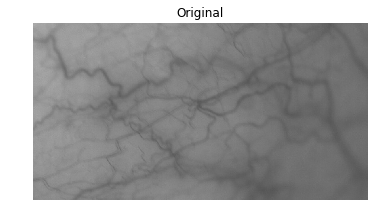

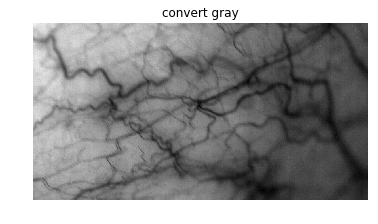

#####################################################
self.oriImg : uint8 tempNorm : float64 self.greenImg : float64 
[0.9        0.91111111 0.91111111 0.88888889 0.87777778 0.86666667
 0.87777778 0.88888889 0.86666667 0.86666667]
#####################################################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
[0.9        0.91111111 0.91111111 0.88888889 0.87777778 0.86666667
 0.87777778 0.88888889 0.86666667 0.86666667]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#####################################################
tempImg : float64 self.claheImg : float64
[0.90143016 0.91677968 0.91677968 0.88885464 0.87350512 0.85821724
 0.87350512 0.88885464 0.85821724 0.85821724]
#####################################################


/Users/hyeonwoojeong/.pyenv/versions/3.5.5/envs/bonoProjects/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


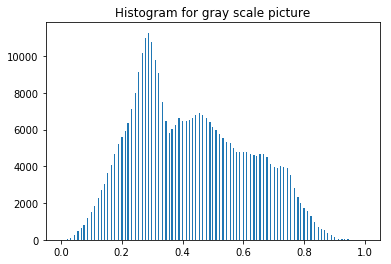

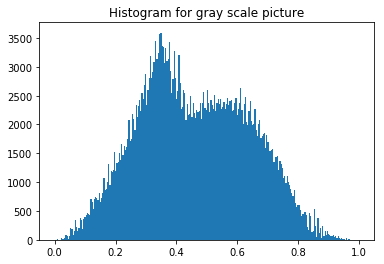

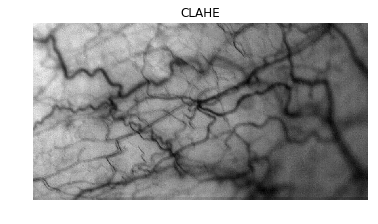

$$$$$$$$$$$$$$$$$$$$$$$$$$$$
439
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tophat 
 [0.01534953 0.         0.         0.01257551 0.02792504 0.04321292
 0.02792504 0.01257551 0.04321292 0.04321292]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
439
#####################################################
tempTophat1 : float64 closeOpenImg : float64 topHatMdfd : float64 
result : float64 
#####################################################


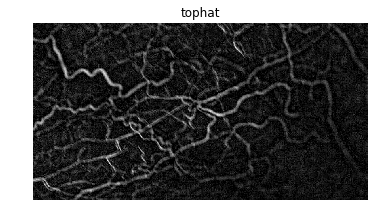

Current Frangi Filter Sigma:  1.0
Current Frangi Filter Sigma:  2.5
0.02179905953592674
0.005981946897356999
#####################################################
hessImg : float64 hessDiff1 : float64 hessDiff2 : float64 
tempLamb1 : float64 tempLamb2 : float64
#####################################################


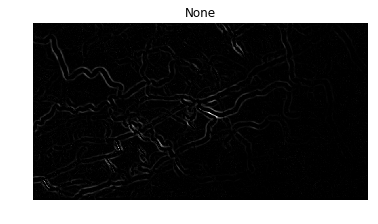

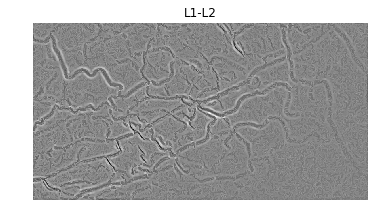

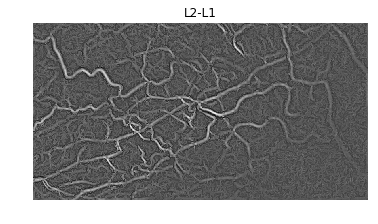

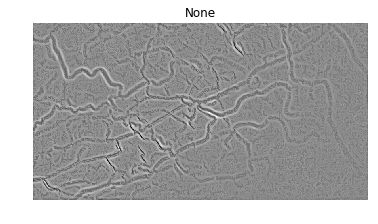

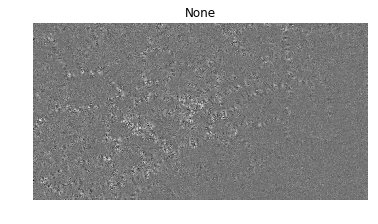

(439, 829)
#####################################################
thresold value : 0.35742187499999994
global_otsu : float64 
#####################################################


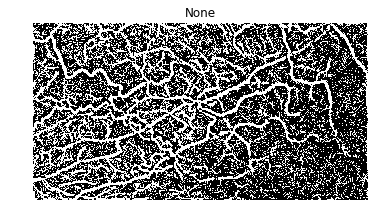

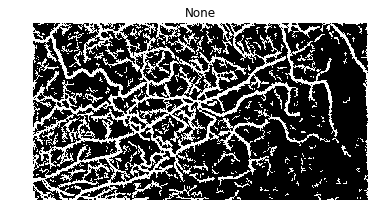

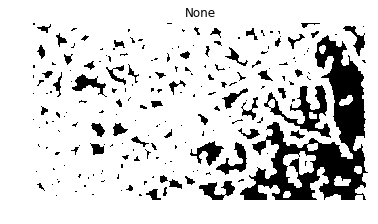

In [7]:
if __name__ == "__main__":
    maskPath = "./DRIVE/DRIVE/test/mask/01_test_mask.gif"
    vesselPath1 ="./DRIVE/DRIVE/training/images/22_training.tif"
    vesselPath2 ="./18.06.25/Image__2018-06-25__14-55-38.jpg"
    vesselPath3 = "./DRIVE/DRIVE/test/images/01_test.tif"
    vesselPath4 = "./18.06.25/Image__2018-06-25__15-23-15.bmp"
    #mmh = khanMethod2016(vesselPath3,maskPath)
    mmh = khanMethod2016(vesselPath2)
    claheImg = mmh.clahe_preprocessing()
    topImg = mmh.tophat_morphology()
    mmh.process_hessian()
    #mmh.multi_otsu_method()
    mmh.otsu_method()
else:
    print("imported")

In [3]:
from skimage import io

path1 = "./DRIVE/DRIVE/test/images/20_test.tif"
path2 = "./DRIVE/DRIVE/test/mask/20_test_mask.gif"

temp1 = cv2.imread(path1)
temp2 = plt.imread(path2)
temp3 = io.imread(path1)

print('temp1 {} , temp2 {} , temp3 {}'.format(temp1.dtype,temp2.dtype,temp3.dtype))
temp1 = cv2.cvtColor(temp1,cv2.COLOR_BGR2GRAY)

qq = np.array([[0,0,1,1,1,1,1,1,1,1,1,0,0],
                [0,1,1,1,1,1,1,1,1,1,1,1,0],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [1,1,1,1,1,1,1,1,1,1,1,1,1],
                [0,1,1,1,1,1,1,1,1,1,1,1,0],
                [0,0,1,1,1,1,1,1,1,1,1,0,0]],dtype = 'uint8')


st = cv2.morphologyEx(temp1,cv2.MORPH_ERODE,qq)

show_on_jupyter(st,'gray')
print(temp1.shape)
print(temp2.shape)

struc = morphology.disk(7)
tempMask = cv2.erode(temp2,struc)
#show_on_jupyter(temp1)
result = np.multiply(temp1,tempMask)
io.imshow(result)

#viewer.show()
print(result.shape)


temp1 uint8 , temp2 uint8 , temp3 uint8


NameError: name 'show_on_jupyter' is not defined

In [ ]:
"""
##  otsu method local + global
    def multi_otsu_method(self,otsu_bins = 1000):
        tempRowCol = (self.imgRow,self.imgCol)
        sumOfPixel = tempRowCol[0] * tempRowCol[1]
        
        p1 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype)
        p2 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype) 
        p3 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype)
        
        print(p1.shape)
        tempHist,tempBins = np.histogram(self.hessDiff1,bins = otsu_bins)
        #first, normlaized data
        tempHist = np.divide(tempHist, sumOfPixel)
        #print(tempSumPixel)
        tempSum=0
        print(np.sum(tempHist))
        
        self.show_histogram(tempHist, color = 'gray', dtype= 'float')
        
        for i in range(1, otsu_bins-2):
            for j in range(i+1, otsu_bins-1):
                p1[i,j] = np.sum(tempHist[0:i])
                p2[i,j] = np.sum(tempHist[i+1 : j])
                p3[i,j] = np.sum(tempHist[j+1 : otsu_bins])
        
        #print(p1)
        #print(p2)
        #print(p3)
        
        intensity = tempBins[0:-1]
        print("length intensity : ",len(intensity))
        m1 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype)
        m2 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype) 
        m3 = np.zeros((otsu_bins,otsu_bins), dtype=self.hessDiff1.dtype)    
        #Second, get mean of each data
        #using baysian probability
        for i in range(1, otsu_bins-2):
            for j in range(i+1, otsu_bins-1):
                m1[i,j] = 1/(p1[i,j]) * (np.sum(np.multiply(intensity[0 : i],tempHist[0 : i]) ) )
                m2[i,j] =  1/(p2[i,j]) * (np.sum(np.multiply(intensity[i+1 : j], tempHist[i+1 : j] ) ) )
                m3[i,j] =  1/(p3[i,j]) * (np.sum(np.multiply(intensity[j+1 : otsu_bins], tempHist[j+1 : otsu_bins]) ) )
        
        mG = np.sum(np.multiply(intensity[0:otsu_bins],tempHist[0:otsu_bins]))
        
        #Third, get varience
        otsuBetweenVariance = np.multiply(p1,np.power(np.subtract(m1,mG),2)) + \
                                          np.multiply(p1,np.power(np.subtract(m1,mG),2)) + \
                                          np.multiply(p1,np.power(np.subtract(m1,mG),2))
        #otsuWithinVarience =
        #get maximum value
        """